In [1]:
import time
import warnings
from numba import jit

import pandas as pd
import numpy as np
import xgboost as xgb
from numpy.random import randn

from sklearn.linear_model import LinearRegression   # 线性回归
from sklearn.linear_model import LogisticRegression # 罗辑回归

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

D:\Work\Code\AboutPython\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid_neg(x):
    return -np.log((1/x)-1)

def load_data(file_list, bath_path, train_or_test):
    df = pd.DataFrame()
    for file in file_list:
        df = pd.concat([df, pd.read_csv(bath_path+file+'_'+train_or_test+'.csv')[['pred']].rename(columns = {'pred':file})],axis=1)
    return df

def standardize(df):
    df[df<1e-5] = 1e-5
    df[df>0.9999] = 0.9999
    return df


def logistic_stack(train, test, y, Logarithm=0, C = 1):
    if Logarithm:
        train = sigmoid_neg(train)
        test = sigmoid_neg(test)
    X = train
    sub=test.copy()
    sub['pred']=0 
    sub_train=train.copy()
    sub_train['pred'] = 0

    K = 5
    skf = StratifiedKFold(n_splits=K, random_state=int(time.time()), shuffle = True)
    for i, (train_index, valid_index) in enumerate(skf.split(train, y)):
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[valid_index,:].copy()
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[valid_index].copy()
        X_test = test.copy()
        
        clf = LogisticRegression(C = C,penalty='l1')
        logistic_model = clf.fit(X=train, y=y)
        #print(logistic_model.coef_)
        
        
        pred_valid = logistic_model.predict_proba(X_valid)[:,1]
        sub_train['pred'].iloc[valid_index] = pred_valid   
        print( "  Gini = ", eval_gini(y_valid, pred_valid) )
        sub['pred'] += logistic_model.predict_proba(X_test)[:,1]/5
        
    return sub_train.pred, sub.pred
    

In [3]:
# 设定参与 ensemble 的数据集
base_path = 'D:/DataSet/Credit/result/'
file_list = ['RF','BayesNet','FFM','gcForest','GLM','linear','NN','RGF','xgboost']

In [5]:
# 根据基于 CV 的 train 与 test 的 ensemble
train = load_data(file_list, base_path,'train')
test = load_data(file_list, base_path,'test')
all_train = pd.read_csv('D:/DataSet/Credit/featured/train_all_feature.csv')
all_test = pd.read_csv('D:/DataSet/Credit/featured/test_all_feature.csv')
y = all_train.y
id_train = all_train.report_id
id_test = all_test.report_id

train = train.fillna(0)
test = test.fillna(0)

STANDARDIZE=1
if STANDARDIZE:
    train = standardize(train)
    test = standardize(test)

In [11]:
pred_train, pred_test = logistic_stack(train, test, y,C=0.1)
eval_gini(y, pred_train)

  Gini =  0.731400059259
  Gini =  0.760349866667
  Gini =  0.747699674074
  Gini =  0.745022103704
  Gini =  0.758330311111


0.74860754488888892

In [12]:
sub_train = pd.DataFrame()
sub_train['report_id'] = id_train
sub_train['y'] = y
sub_train['pred'] = pred_train

sub = pd.DataFrame()
sub['report_id'] = id_test
sub['pred'] = pred_test

In [14]:
base_path = 'D:/DataSet/Credit/'
sub_train.to_csv(base_path+'result/BadEnsemble_train.csv', index=False)
sub.to_csv(base_path+'result/BadEnsemble_test.csv', index=False)

In [16]:
gini_linear = [ 0.64327416,  0.64305371,  0.63622826,  0.64837088,  0.641729  ,
                0.64326163,  0.64639222,  0.64632741,  0.64368288,  0.64296834,
                0.64481187,  0.64310028,  0.64041114,  0.64655438,  0.64319435,
                0.64360623,  0.64504919,  0.63327169,  0.64263482,  0.64103735]

gini_GLM = [0.6479519,0.6414335,0.6510817,0.6496927,0.6496927,0.6414335,0.6436756,0.6496927,0.6510817,0.6479519,
            0.6496927,0.6554539,0.6496927,0.6522328,0.6496927,0.6496927,0.6522328,0.6479519,0.6496927,0.6460173]

gini_FFM = [ 0.69734353,  0.69935571,  0.69736377,  0.69859219,  0.69691345,
             0.69792305,  0.70043716,  0.69755102,  0.70020722,  0.69548079,
             0.69682352,  0.69716144,  0.69884599,  0.70421066,  0.70004131,
             0.69899116,  0.70005649,  0.69872906,  0.69961545,  0.69964086]

gini_NN = [ 0.70589662,  0.70521589,  0.70641959,  0.70720891,  0.70378258,
            0.70599322,  0.70360836,  0.70499837,  0.70715749,  0.70522711,
            0.70500614,  0.70336296,  0.70398523,  0.70526469,  0.70636087,
            0.70489637,  0.70788559,  0.70526513,  0.70595756,  0.70495118]

gini_RF = [0.7266895075555555,0.7277804468148148,0.72487061807407405,0.72709853866666663,0.72841635081481482,
           0.72629101985185185,0.72920498251851851,0.72892709925925925,0.7257895253333333,0.72771320414814822,
           0.72748963081481488,0.72599542518518523,0.72701498785185192,0.72737149155555558,0.72638913422222218,
           0.72785129244444446,0.7272233908148148,0.72860207407407407,0.72695794725925933,0.72880323318518525]

gini_GBDT = [0.75120118518518519,0.75114664770370365,0.74995766992592594,0.75118514251851853,0.74984495407407414,
             0.74977232592592591,0.75092406044444449,0.75085947259259256,0.75035005155555556,0.75163831940740744,
             0.75031720770370369,0.74898820740740746,0.74959138133333325,0.75295010133333329,0.75161783940740734,
             0.74984813985185184,0.75138812207407413,0.75076268562962967,0.75325548088888894,0.75124589985185186]

gini_gcForest = [ 0.7326092 ,  0.73335442,  0.73270985,  0.73452026,  0.73467718,
                  0.73519438,  0.73711918,  0.73342476,  0.73575506,  0.73308102,
                  0.73610777,  0.73504315,  0.73685713,  0.73235504,  0.73441886,
                  0.73304919,  0.73451046,  0.73365543,  0.73245099,  0.73417178]

gini_bayes = [0.6041149,0.6056682,0.6066511,0.6052054,0.6071013,0.6046448,0.6073083,0.6064379,0.6056368,0.6054955,
              0.6059207,0.6049628,0.6050127,0.6048918,0.6071361,0.6068617,0.6071862,0.6057095,0.6072833,0.6078883]

gini_Ensemble = [ 0.75604198,  0.75692737,  0.75686126,  0.75646863,  0.75771444,
                  0.75683849,  0.75760401,  0.7554091 ,  0.75635372,  0.75657036,
                  0.75616838,  0.75725415,  0.75769364,  0.75601178,  0.75665287,
                  0.75782784,  0.75579275,  0.75739115,  0.75702754,  0.75753916]

gini_badEnsemble = [ 0.74907104,  0.7483153 ,  0.7503325 ,  0.74892265,  0.74892569,
                     0.74734124,  0.74876801,  0.74945631,  0.74674256,  0.74750403,
                     0.74830529,  0.74738711,  0.74715669,  0.74909609,  0.74801221,
                     0.74876808,  0.74847913,  0.75140363,  0.74721984,  0.74877979]

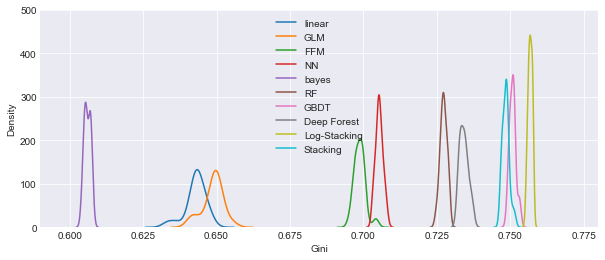

In [17]:
fig = plt.figure()
fig.set(alpha=0.9)
fig.set_size_inches(10, 4)

pd.Series(gini_linear).plot(kind='kde')
pd.Series(gini_GLM).plot(kind='kde')
pd.Series(gini_FFM).plot(kind='kde')

pd.Series(gini_NN).plot(kind='kde')
pd.Series(gini_bayes).plot(kind='kde')

pd.Series(gini_RF).plot(kind='kde')
pd.Series(gini_GBDT).plot(kind='kde')
pd.Series(gini_gcForest).plot(kind='kde')

pd.Series(gini_Ensemble).plot(kind='kde')
pd.Series(gini_badEnsemble).plot(kind='kde')

plt.legend(['linear','GLM','FFM','NN','bayes','RF','GBDT','Deep Forest','Log-Stacking','Stacking'],loc='best')

plt.xlabel('Gini')
plt.ylim(0,500)
plt.xlim(0.59,0.78)
plt.show()